# はじめに
機械学習モデルを公平性の観点から評価します。  

### 概要
- 収入を予測するモデルの予測が、性別によらず公平かどうかを評価します。  
- 公平性指標としてEqualized Oddsを使用します。
- 公平性指標を考慮してモデルの学習を行った場合の公平性も評価します。

# 公平性指標  
### Equalized Odds  
今回考える公平性指標は、性別や人種などの各グループが公平に扱われているか（group fairness）を評価するために用いられます。  
Equalized Oddsは、positiveとnegativeの2クラス分類において、positiveと判定される確率に着目した指標です。  
具体的には、正しくpositiveと判定される確率（true positive rate）と、誤ってpositiveと判定される確率（false positive rate）がグループによらず等しいかを評価します。  


採用を判定するモデルでは、採用と判定されるべき人が正しく採用と判定される確率と、不採用と判定されるべき人が誤って採用と判定される確率が、男性と女性で等しいかを評価します。


数式で書くと、性別や人種などの属性の集合を$A$、モデルが予測するクラスの集合を$Y=\{0,1\}$、属性が$a \in A$かつ正解クラスが$y \in Y$のデータが、クラス1と予測（$\hat{Y} =1$）される確率を$P(\hat{Y}=1|A=a, Y=y)$とすると、任意の$y, a, a'$で下記が成り立つ場合、モデルはEqualized Oddsを満たします。

$$
P(\hat{Y}=1|A=a, Y=y) = P(\hat{Y}=1|A=a', Y=y)
$$

### Equalized Opportunity  
類似の指標として、true positive rateのみに着目したEqualized Opportunityもあります。  
任意の$a, a'$で下記が成り立つ場合、モデルはEqualized Opportunityを満たします。  

$$
P(\hat{Y}=1|A=a, Y=1) = P(\hat{Y}=1|A=a', Y=1)
$$



# 実装

### 1. ライブラリのインポート
必要なライブラリをインポートします。

In [ ]:
import sys
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import lightgbm as lgb

!pip install fairlearn
from fairlearn.datasets import fetch_adult
from fairlearn.reductions import EqualizedOdds, ExponentiatedGradient
from fairlearn.metrics import equalized_odds_difference, MetricFrame, true_positive_rate, false_positive_rate, count

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 5.0 MB/s eta 0:00:00


### 2. データセットの用意  
今回は[Adult Data Set](http://archive.ics.uci.edu/ml/datasets/adult)を使用します。  
年齢や教育歴などの14の属性から、収入が5万ドルを超えるかどうかを予測するタスクのデータセットで、48,842サンプルが含まれます。  
UCI Machine Learning Repositoryからダウンロードすることもできますが、Fairlearnのfetch_adultで取得します。

In [ ]:
X, y = fetch_adult(return_X_y=True, as_frame=True)
print(X.head())
print(X.shape)
print(set(y))

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


    age  workclass    fnlwgt     education  education-num      marital-status  \
0  25.0    Private  226802.0          11th            7.0       Never-married   
1  38.0    Private   89814.0       HS-grad            9.0  Married-civ-spouse   
2  28.0  Local-gov  336951.0    Assoc-acdm           12.0  Married-civ-spouse   
3  44.0    Private  160323.0  Some-college           10.0  Married-civ-spouse   
4  18.0        NaN  103497.0  Some-college           10.0       Never-married   

          occupation relationship   race     sex  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male           0.0           0.0   
1    Farming-fishing      Husband  White    Male           0.0           0.0   
2    Protective-serv      Husband  White    Male           0.0           0.0   
3  Machine-op-inspct      Husband  Black    Male        7688.0           0.0   
4                NaN    Own-child  White  Female           0.0           0.0   

   hours-per-week native-country

データを7:3にランダムに分割して、それぞれを教師データとテストデータとして使用します。  
ラベルは、Fairlearnで用いられるように'>50K'は1、'<=50K'は0となるように変換しておきます。  

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
y_train = (y_train == '>50K') * 1
y_test = (y_test == '>50K') * 1

### 3. 学習  
LightGBMでモデルの学習を行います。  
テスト精度も確認しておきます。

In [ ]:
lgb_params = {
    'objective' : 'binary',
    'metric' : 'accuracy',
}
model = lgb.LGBMClassifier(**lgb_params)
model.fit(X_train, y_train)

pred = model.predict(X_test)
print('test accuracy', accuracy_score(y_test, pred))

test accuracy 0.8799563229372824


### 4. 公平性評価
Fairlearnのequalized_odds_differenceで、性別ごとのグループ間の不公平度を計算します。  
この関数は、sensitive_featuresに指定した属性のグループ間のtrue positive rateまたはfalse positive rateの差の最大値を出力します。

In [ ]:
equalized_odds_difference(y_test, pred, sensitive_features=X_test['sex'])

0.10099689214204444

グループごとの精度、true positive rate、false positive rate、サンプル数をMetricFrameを用いて確認します。  
true positive rateの差がequalized_odds_differenceの値と一致していることも確認できます。  

accuracy                   0.879956
true positive rate         0.672222
false positive rate        0.056797
count                  14653.000000
dtype: float64
        accuracy  true positive rate  false positive rate   count
sex                                                              
Female  0.942074            0.586139             0.016567  4851.0
Male    0.849214            0.687136             0.082184  9802.0


array([[<Axes: title={'center': 'accuracy'}, xlabel='sex'>,
        <Axes: title={'center': 'true positive rate'}, xlabel='sex'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='sex'>,
        <Axes: title={'center': 'count'}, xlabel='sex'>]], dtype=object)

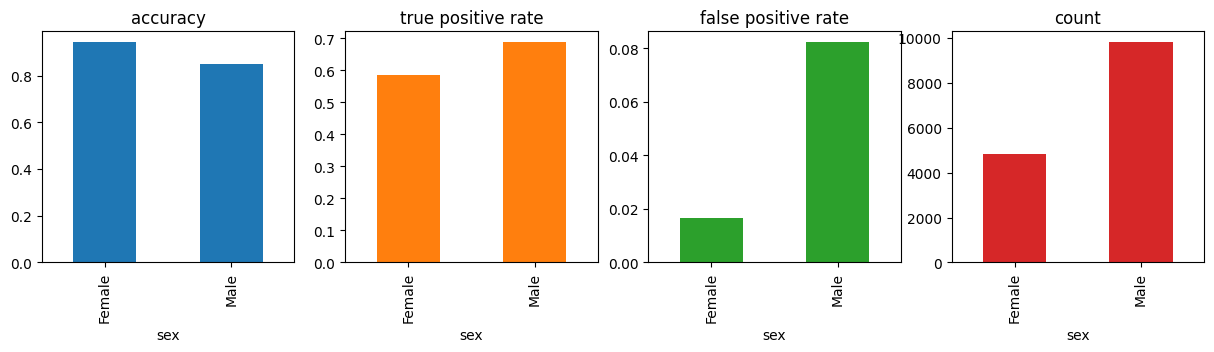

In [ ]:
metric_frame = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "true positive rate": true_positive_rate,
        "false positive rate": false_positive_rate,
        "count": count,
    },
    sensitive_features=X_test['sex'],
    y_true=y_test,
    y_pred=pred,
)
print(metric_frame.overall)
print(metric_frame.by_group)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[1, 4],
    legend=False,
    figsize=[15, 3],
)

### 5. 公平性指標を考慮した学習  
FairlearnのExponentiatedGradientを用いて、公平性が改善するように学習を行います。

In [ ]:
model_fair = lgb.LGBMClassifier(**lgb_params)
mitigator = ExponentiatedGradient(model_fair, EqualizedOdds())
mitigator.fit(X_train, y_train, sensitive_features=X_train['sex'])
pred = mitigator.predict(X_test)
print('test accuracy', accuracy_score(y_test, pred))

test accuracy 0.8774994881594212


先ほどと同様に公平性の評価を行います。

equalized odds difference 0.0364994990065044
accuracy                   0.877499
true positive rate         0.626316
false positive rate        0.046025
count                  14653.000000
dtype: float64
        accuracy  true positive rate  false positive rate   count
sex                                                              
Female  0.941455            0.657426             0.025541  4851.0
Male    0.845848            0.620926             0.058952  9802.0


array([[<Axes: title={'center': 'accuracy'}, xlabel='sex'>,
        <Axes: title={'center': 'true positive rate'}, xlabel='sex'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='sex'>,
        <Axes: title={'center': 'count'}, xlabel='sex'>]], dtype=object)

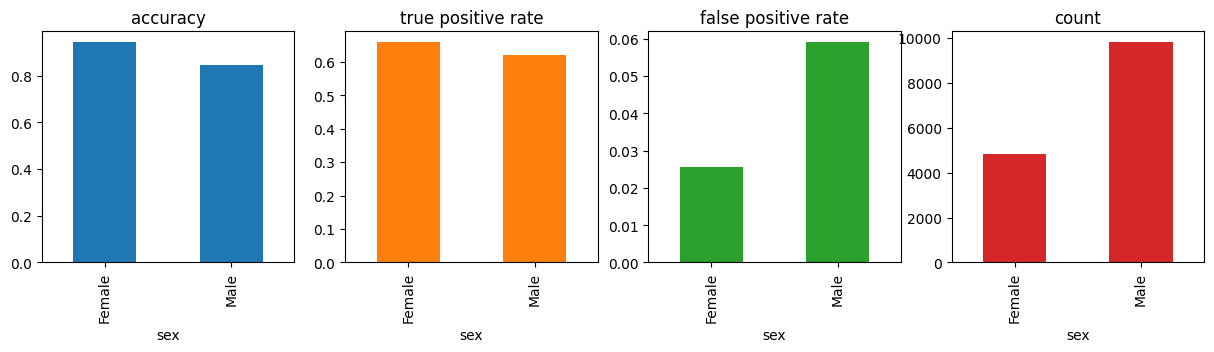

In [ ]:
print('equalized odds difference', equalized_odds_difference(y_test, pred, sensitive_features=X_test['sex']))
metric_frame = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "true positive rate": true_positive_rate,
        "false positive rate": false_positive_rate,
        "count": count,
    },
    sensitive_features=X_test['sex'],
    y_true=y_test,
    y_pred=pred,
)
print(metric_frame.overall)
print(metric_frame.by_group)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[1, 4],
    legend=False,
    figsize=[15, 3],
)

# おわりに

### 今回の結果
通常の学習では、Equalized Oddsが満たされないこと、公平性を考慮した学習を行うことで、公平性を改善できることが確認できました。  
一方で、テスト精度は、公平性を考慮することで少し低下しています。  
公平性とテスト精度を両立できるかも重要な観点となります。  

### 次にやること
公平性を改善するために様々な手法が提案されているので、各手法の効果、公平性と精度のトレードオフについて検証したいと思います。  

### 参考資料
- Adult Data Set  
http://archive.ics.uci.edu/ml/datasets/adult
- Fairlearn  
https://fairlearn.org/v0.8/quickstart.html

